In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from scipy.ndimage.filters import gaussian_filter

import torch
from torch.utils.data import DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 30)

np.set_printoptions(threshold=200)
mpl.rcParams['animation.embed_limit'] = 100

pitch_size = [108, 72]

/tmp/ipykernel_56720/148541870.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
%load_ext autoreload
%autoreload 2

from dataset import SoccerDataset
from target_poss_encoder import TargetPossEncoder
from trace_regressor import *
from poss_classifier import *
from postprocessor import Postprocessor

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
files = glob('data/metrica_traces/*.csv')
files.sort()
train_files = files[:-1]
val_files = files[-1:]
train_files, val_files

(['data/metrica_traces/game_1.csv',
  'data/metrica_traces/game_2.csv',
  'data/metrica_traces/game_3.csv'],
 ['data/metrica_traces/real_test.csv'])

### GK Trace Prediction

In [5]:
session_name = val_files[0].split('.')[0]
data = pd.read_csv(f'{session_name}.csv', header=0, index_col=0)
data

episode     A01_x     A01_y  A01_speed     A01_accel     A02_x     A02_y  A02_speed  A02_accel     A03_x     A03_y  A03_speed  A03_accel     A04_x     A04_y  ...  B08_accel     B09_x     B09_y  B09_speed  B09_accel     B10_x     B10_y  \
0          493  91.49976  38.05560   0.000000  0.000000e+00  70.48944  17.85024   0.000000   0.000000  71.84700  33.52464   0.000000   0.000000  73.55124  42.53976  ...   0.000000  44.51220  26.41608   0.000000   0.000000  50.81400  52.71768   
1          493  91.49976  38.05560   0.000000  0.000000e+00  70.39602  17.52300   3.403136  -2.464983  71.78058  33.48900   0.753779  -0.369316  73.51614  42.48792  ...  -1.395487  44.41392  25.92072   5.050153  -4.135498  50.86422  52.73820   
2          493  91.49976  38.05560   0.000000  0.000000e+00  70.33068  17.45568   0.938152   0.311511  71.76168  33.45552   0.384463   0.090791  73.47996  42.44760  ...  -0.638206  44.41176  25.82928   0.914655  -0.212572  50.98464  52.77816   
3          493  91.49976  38.05560   0.000000  0.000000e+00  70.31394  17.33184   1.249663   0.298422  71.80920  33.45624   0.475255   0.737128  73.47618  42.44472  ...   0.047505  44.41284  25.75908   0.702083   0.258476  51.12396  52.82712   
4          493  91.49976  38.05560   0.000000  0.000000e+00  70.31556  17.17704   1.548085  -0.396072  71.89776  33.37344   1.212383   0.315990  73.48104  42.46704  ...  -0.114531  44.39664  25.66440   0.960559   0.422464  51.26760  52.81632   
...        ...       ...       ...        ...           ...       ...       ...        ...        ...       ...       ...        ...        ...       ...       ...  ...        ...       ...       ...        ...        ...       ...       ...   
21776      539  99.49716  31.64472   0.220608 -6.680783e-03  48.29220   0.74808   2.608398   0.160049  59.32872   5.75496   2.408479   0.262530  67.78080  34.22088  ...   0.004921  26.17596  36.51696   0.903657   0.127641  53.22780  27.88848   
21777      539  99.50526  31.62492   0.213928  6.680783e-03  48.55842   0.67212   2.768447   0.039297  59.37840   5.49252   2.671008   0.237642  67.82778  34.07508  ...  -0.089389  26.27640  36.49356   1.031298   0.047033  53.06904  27.64260   
21778      539  99.51336  31.60440   0.220608 -1.234846e-13  48.83220   0.60984   2.807744   0.054077  59.44104   5.20848   2.908651   0.169571  67.87476  33.93576  ...  -0.020717  26.38116  36.46800   1.078331   0.099948  52.92432  27.39528   
21779      539  99.52146  31.58388   0.220608 -6.680783e-03  49.10058   0.51048   2.861822  -0.292253  59.51502   4.90968   3.078222   0.156386  67.93092  33.81012  ...  -0.069487  26.49888  36.46296   1.178278   0.089929  52.79310  27.15480   
21780      539  99.52956  31.56408   0.213928  1.087075e-02  49.33440   0.40392   2.569569  -0.324958  59.60628   4.59936   3.234608  -0.039456  67.99680  33.69168  ...  -0.079470  26.62524  36.47376   1.268207   0.039630  52.67808  26.91720   

       B10_speed  B10_accel     B11_x     B11_y  B11_speed  B11_accel    ball_x    ball_y  
0       0.000000   0.000000  52.77312  26.17704   0.000000   0.000000  54.13500  35.08200  
1       0.542505   0.726265  52.70778  26.15400   0.692832   0.063804  54.13500  35.08200  
2       1.268770   0.207954  52.67700  26.08488   0.756636  -0.268956  54.13500  35.08200  
3       1.476724  -0.036270  52.66458  26.03772   0.487680  -0.253231  54.13500  35.08200  
4       1.440454   0.100515  52.65000  26.01936   0.234450   0.007936  54.13500  35.08200  
...          ...        ...       ...       ...        ...        ...       ...       ...  
21776   3.059094  -0.132292  55.66752  36.78408   0.464498   0.021116  53.13924   1.29816  
21777   2.926802  -0.061299  55.65456  36.83088   0.485613   0.067300  53.79264   0.97668  
21778   2.865503  -0.125990  55.64268  36.88488   0.552914   0.247947  54.43956   0.65880  
21779   2.739513  -0.099752  55.63080  36.96408   0.800860   0.003488  55.08594   0.34020  
21780   2.639761   0.129971  55.61676  37.04328   0.80

In [6]:
data.episode.unique()

array([493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505,
       506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
       519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531,
       532, 533, 534, 535, 536, 537, 538, 539])

In [7]:
len(data[data.episode == 538])

1088

In [8]:
target_type = 'gk'
model_type = 'setlstm'
loss_type = 'mse_no'

if model_type == 'lstm':
    gk_regressor = TraceLSTM(target_type=target_type).to(device)
elif model_type == 'setlstm':
    gk_regressor = TraceSetLSTM(target_type=target_type).to(device)
elif model_type == 'seq2seq':
    gk_regressor = TraceSeq2Seq(target_type=target_type).to(device)
elif model_type == 'seq2seq':
    gk_regressor = TraceSetLSTM(target_type=target_type).to(device)
elif model_type == 'transformer':
    gk_regressor = TraceTransformer(target_type=target_type).to(device)
elif model_type == 'settransformer':
    gk_regressor = TraceSetTransformer(target_type=target_type).to(device)

#model_path = f'saved_models/{target_type}_{model_type}_{loss_type}.pt'
#gk_regressor.load_state_dict(torch.load(model_path))

In [9]:
episode = 508

episode_idxs = data[data['episode'] == episode].index

num_players = 10
input_cols_x = [f'{team}{i:02d}_x' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
input_cols_y = [f'{team}{i:02d}_y' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
input_cols_speed = [f'{team}{i:02d}_speed' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
input_cols_accel = [f'{team}{i:02d}_accel' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
input_cols = np.vstack((input_cols_x, input_cols_y, input_cols_speed, input_cols_accel)).ravel('F').tolist()
target_cols = ['A11_x', 'A11_y', 'B11_x', 'B11_y']

#heatmaps = np.load(f'data/fm_heatmaps_no_gk/{session_name}.npy')
#heatmaps.shape

input_traces = data.loc[episode_idxs, input_cols].values
input_heatmaps_tensor = torch.zeros(1, input_traces.shape[0], 2, 108, 72).to(device, dtype=torch.float)
target_traces = data.loc[episode_idxs, target_cols].values

pred_traces = gk_regressor.forward(input_heatmaps_tensor, torch.FloatTensor(input_traces).unsqueeze(0).to(device), target_traces)
pred_traces = pred_traces[0].detach().cpu().numpy()

print(f'Input trace dim     : {input_traces.shape}')
#print(f'Input heatmap dim   : {input_heatmaps.shape}')
print(f'Target trace dim    : {target_traces.shape}')
print(f'Predicted trace dim : {pred_traces.shape}')

Input trace dim     : (1070, 80)
Target trace dim    : (1070, 4)
Predicted trace dim : (1070, 4)


max_frames = 20
pp = Postprocessor(input_traces, target_traces, pred_traces, target_type='gk')
feats = [np.arange(min(max_frames, input_traces.shape[0])) + episode_idxs[0]]
anim = pp.visualize(feats, max_frames=max_frames)
HTML(anim.to_jshtml())

### Ball Trace Prediction

In [10]:
gk_trace_pred = False
team_poss_pred = True

In [11]:
target_type = 'ball'
model_type = 'setlstm'
loss_type = 'mse_no'

if model_type == 'lstm':
    ball_regressor = TraceLSTM(target_type=target_type).to(device)
elif model_type == 'setlstm':
    ball_regressor = TraceSetLSTM(target_type=target_type).to(device)
elif model_type == 'seq2seq':
    ball_regressor = TraceSeq2Seq(target_type=target_type).to(device)
elif model_type == 'transformer':
    ball_regressor = TraceTransformer(target_type=target_type).to(device)
elif model_type == 'settransformer':
    ball_regressor = TraceSetTransformer(target_type=target_type).to(device)

# model_path = f'saved_models/{target_type}_{model_type}_{loss_type}.pt'
# print(ball_regressor.load_state_dict(torch.load(model_path)))

if team_poss_pred:
    poss_classifier = PossTransformerClassifier(ball_trace_given=False, mode='team', hidden_dim=128).to(device).eval()
    model_path = f'saved_models/possclaasifier_128_32_pysic_True.pt'
    print(poss_classifier.load_state_dict(torch.load(model_path)))

<All keys matched successfully>


In [12]:
#if not gk_trace_pred:
#    heatmaps = np.load(f'data/fm_heatmaps_true_gk/{session_name}.npy')
#    print(heatmaps.shape)

In [13]:
def compute_heatmaps(traces, sigma=2):
    num_players = traces.shape[0] // 2
    pitch_size = [108, 72]
    pitch_range = [[0, pitch_size[0]], [0, pitch_size[1]]]
    
    team1_x = traces[0:num_players:2]
    team1_y = traces[1:num_players:2]
    team2_x = traces[num_players::2]
    team2_y = traces[num_players+1::2]
    
    heatmap1 = np.histogram2d(team1_x, team1_y, bins=pitch_size, range=pitch_range)[0]
    heatmap1 = gaussian_filter(heatmap1, sigma=sigma)
    heatmap2 = np.histogram2d(team2_x, team2_y, bins=pitch_size, range=pitch_range)[0]
    heatmap2 = gaussian_filter(heatmap2, sigma=sigma)
    
    return np.stack([heatmap1, heatmap2])

In [14]:
if gk_trace_pred:
    input_team1_traces = np.concatenate([input_traces[:, :40], pred_traces[:, :2], pred_traces[:, :2]], axis=1)
    input_team2_traces = np.concatenate([input_traces[:, 40:], pred_traces[:, 2:], pred_traces[:, 2:]], axis=1)
    input_traces = np.concatenate([input_team1_traces, input_team2_traces], axis=1)
    
    heatmap_list = []
    tqdm_iter = tqdm(range(input_traces.shape[0]), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    #for i in tqdm_iter:
    #    moment_heatmaps = compute_heatmaps(input_traces[i])
    #    heatmap_list.append(moment_heatmaps)
    #input_heatmaps = np.array(heatmap_list)
    
else:
    num_players = 11
    input_cols_x = [f'{team}{i:02d}_x' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
    input_cols_y = [f'{team}{i:02d}_y' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
    input_cols_speed = [f'{team}{i:02d}_speed' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
    input_cols_accel = [f'{team}{i:02d}_accel' for team in ['A', 'B'] for i in np.arange(num_players) + 1]
    input_cols = np.vstack((input_cols_x, input_cols_y, input_cols_speed, input_cols_accel)).ravel('F').tolist()
    #input_cols = np.vstack((input_cols_x, input_cols_y)).ravel('F').tolist()
    input_traces = data.loc[episode_idxs, input_cols].values
    
    # input_heatmaps = heatmaps[episode_idxs]

print(input_traces.shape)

target_cols = ['ball_x', 'ball_y']
target_traces = data.loc[episode_idxs, target_cols].values

#input_heatmaps_tensor = torch.tensor(input_heatmaps).unsqueeze(0).to(device, dtype=torch.float)
input_trace_tensor = torch.tensor(input_traces).unsqueeze(0).to(device, dtype=torch.float)
input_heatmaps_tensor = torch.zeros(1, input_traces.shape[0], 2, 108, 72).to(device, dtype=torch.float)
pred_traces, pred_team_poss_scores = ball_regressor.forward(input_heatmaps_tensor, input_trace_tensor, target_traces)
pred_traces = pred_traces[0].detach().cpu().numpy()

print(f'Input trace dim     : {input_traces.shape}')
# print(f'Input heatmap dim   : {input_heatmaps.shape}')
print(f'Target trace dim    : {target_traces.shape}')
print(f'Predicted trace dim : {pred_traces.shape}')

pred_traces = pred_traces[:,-2:]
pred_team_poss = pred_team_poss_scores.cpu().detach().numpy()
pred_team_poss = F.one_hot(torch.argmax(torch.tensor(pred_team_poss), -1), 3).numpy()

(1070, 88)
Input trace dim     : (1070, 88)
Target trace dim    : (1070, 2)
Predicted trace dim : (1070, 46)


In [15]:
target_tensor = torch.FloatTensor(target_traces).unsqueeze(0).cuda()

target_tensor = torch.zeros(target_tensor.shape).cuda()

# random_mask = (torch.cuda.FloatTensor(1, target_tensor.shape[1]).uniform_() < 0.1).unsqueeze(-1).cuda()
# target_tensor = target_tensor * random_mask

In [16]:
if True:
    poss_classifier.eval()
    pred_team_poss_scores, pred_traces , _  = poss_classifier.predict2(input_heatmaps_tensor, input_trace_tensor, target_tensor, mask=False)
    pred_traces = pred_traces[0].detach().cpu().numpy()
    pred_team_poss = F.one_hot(torch.tensor(pred_team_poss_scores), 3).numpy() # torch.nn.Softmax(dim=-1)(pred_team_poss_scores).detach().cpu().numpy()
    print(f'Team poss prob dim  : {pred_team_poss.shape}')

    ### debug target ###
    # pred_traces = target_traces
    ### debug target ###

/home/toc/anaconda3/envs/balltrack/lib/python3.8/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorCompare.cpp:333.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Team poss prob dim  : (1, 1070, 3)


/tmp/ipykernel_56720/146637523.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_team_poss = F.one_hot(torch.tensor(pred_team_poss_scores), 3).numpy() # torch.nn.Softmax(dim=-1)(pred_team_poss_scores).detach().cpu().numpy()


### Post-processing the Predicted Ball Trace

In [17]:
pp = Postprocessor(input_traces, episode, target_traces, pred_traces, np.array(torch.tensor(pred_team_poss[0])))
#pp = Postprocessor(input_traces, target_traces, target_traces, None)
pp.accel_thres = 5.0
pp.construct_ball_df()
pp.ball_df

x         y  nearest  nearest_dist     speed     accel  poss_id  team_poss  player_poss     vel_x     vel_y  speed_smooth       cos  touch  x_revise  y_revise
0     49.136417  3.845463       16      6.457430  0.000000  0.000000        1          2           16  0.000000  0.000000      0.826451  1.000000      0  53.34606  -1.05120
1     49.230236  4.017808       16      6.443485  1.962262  0.207731        1          2           16  0.938187  1.723449      1.102512  0.630203     16  53.30880  -0.97056
2     49.147640  4.218473       16      6.617488  2.169993 -0.789689        1          2           16 -0.825958  2.006655      1.349454  0.925568      0  53.30880  -0.92700
3     49.147335  4.356503       16      6.704190  1.380304 -0.145592        1          2           16 -0.003052  1.380301      1.585753  0.982221      0  53.32392  -0.88776
4     49.170246  4.477830       16      6.774965  1.234712 -0.053219        1          2           16  0.229111  1.213269      1.419195  0.996531      0  53.36766  -0.84024
...         ...       ...      ...           ...       ...       ...      ...        ...          ...       ...       ...           ...       ...    ...       ...       ...
1065  58.352493  4.239701        6      2.314690  3.011462 -0.201443       29          1            6 -2.921562 -0.730329      3.057500  0.999823      0  59.36868   2.16000
1066  58.081211  4.166434        6      2.714200  2.810019 -0.128707       29          1            6 -2.712822 -0.732670      2.954925  0.998823      0  59.52204   1.86624
1067  57.826050  4.084050        6      3.135881  2.681312  0.323669       29          1            6 -2.551613 -0.823836      3.258206  0.999761      0  59.67648   1.55232
1068  57.542175  3.985489        6      3.594288  3.004981  1.778275       29          1            6 -2.838745 -0.985615      3.612565  0.999796      0  59.83200   1.21500
1069  57.087234  3.837759        6      4.132322  4.783256  0.000000       29          1            6 -4.549408 -1.477301      4.007212  0.999796      0  59.96916   0.87624

[1070 rows x 16 columns]

In [18]:
previous_pos = pp.ball_df.iloc[0].player_poss
for i in range(len(pp.ball_df)):
    current_pos = pp.ball_df.iloc[i].player_poss
    if current_pos == 0 and previous_pos != 0:
        trans_start = i
        trans_start_pos = previous_pos
        
    if current_pos != 0 and previous_pos == 0:
        if trans_start_pos == current_pos:
            pp.ball_df.iloc[trans_start:i, pp.ball_df.columns.get_loc('player_poss')] = trans_start_pos
        
    previous_pos = current_pos

In [19]:
episode_data = data[data['episode'] == episode]
episode_data['session'] = session_name
episode_data = episode_data[['session'] + episode_data.columns[:-1].tolist()]

/tmp/ipykernel_56720/4101506536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  episode_data['session'] = session_name


In [20]:
tpe = TargetPossEncoder(episode_data.values, pitch_size)
tpe.run()

In [21]:
pp.ball_df['gt_team_poss'] = tpe.team_poss
pp.ball_df['gt_player_poss'] = np.argmax(tpe.player_poss[:, 0:23], axis=-1)

In [22]:
print("Transition Accuracy:", ((pp.ball_df['player_poss'] == 0) == (pp.ball_df['gt_player_poss'] == 0)).mean().round(5) * 100)
print("Player Possession Accuracy:", (pp.ball_df['player_poss'] == pp.ball_df['gt_player_poss']).mean().round(5) * 100)
print("Team Possession Accuracy:", (pp.ball_df['team_poss'] == pp.ball_df['gt_team_poss']).mean().round(5) * 100)

Transition Accuracy: 47.382999999999996
Player Possession Accuracy: 28.598000000000003
Team Possession Accuracy: 87.85


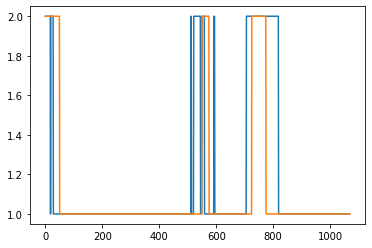

In [23]:
plt.plot(pp.ball_df.gt_team_poss)
plt.plot(pp.ball_df.team_poss)

In [24]:
plt.plot(pp.ball_df.gt_player_poss)
plt.plot(pp.ball_df.player_poss)

In [25]:
pp.ball_df

x         y  nearest  nearest_dist     speed     accel  poss_id  team_poss  player_poss     vel_x     vel_y  speed_smooth       cos  touch  x_revise  y_revise  gt_team_poss  gt_player_poss
0     49.136417  3.845463       16      6.457430  0.000000  0.000000        1          2           16  0.000000  0.000000      0.826451  1.000000      0  53.34606  -1.05120             2               0
1     49.230236  4.017808       16      6.443485  1.962262  0.207731        1          2           16  0.938187  1.723449      1.102512  0.630203     16  53.30880  -0.97056             2               0
2     49.147640  4.218473       16      6.617488  2.169993 -0.789689        1          2           16 -0.825958  2.006655      1.349454  0.925568      0  53.30880  -0.92700             2               0
3     49.147335  4.356503       16      6.704190  1.380304 -0.145592        1          2           16 -0.003052  1.380301      1.585753  0.982221      0  53.32392  -0.88776             2               0
4     49.170246  4.477830       16      6.774965  1.234712 -0.053219        1          2           16  0.229111  1.213269      1.419195  0.996531      0  53.36766  -0.84024             2               0
...         ...       ...      ...           ...       ...       ...      ...        ...          ...       ...       ...           ...       ...    ...       ...       ...           ...             ...
1065  58.352493  4.239701        6      2.314690  3.011462 -0.201443       29          1            6 -2.921562 -0.730329      3.057500  0.999823      0  59.36868   2.16000             1               6
1066  58.081211  4.166434        6      2.714200  2.810019 -0.128707       29          1            6 -2.712822 -0.732670      2.954925  0.998823      0  59.52204   1.86624             1               6
1067  57.826050  4.084050        6      3.135881  2.681312  0.323669       29          1            6 -2.551613 -0.823836      3.258206  0.999761      0  59.67648   1.55232             1               0
1068  57.542175  3.985489        6      3.594288  3.004981  1.778275       29          1            6 -2.838745 -0.985615      3.612565  0.999796      0  59.83200   1.21500             1               0
1069  57.087234  3.837759        6      4.132322  4.783256  0.000000       29          1            6 -4.549408 -1.477301      4.007212  0.999796      0  59.96916   0.87624             1               0

[1070 rows x 18 columns]

In [26]:
print(torch.norm(torch.tensor(pp.ball_df.values[:,0:2]) - target_traces, dim=-1).mean().item())
print(torch.norm(torch.tensor(pp.ball_df.values[:,-4:-2]) - target_traces, dim=-1).mean().item())

5.867384254280408
7.033805374647954


In [27]:
max_frames = 100
frames = min(max_frames, input_traces.shape[0])

feats = []
feats.append(np.arange(frames) + episode_idxs[0])
#feats.append(pp.pred_team_poss[:, 0].round(2))
feats.append(pp.ball_df['player_poss'])
feats.append(pp.ball_df['gt_player_poss'])
feats.append(pp.ball_df['team_poss'])
feats.append(pp.ball_df['gt_team_poss'])
feats.append(pp.ball_df['nearest_dist'].round(2))
feats.append(pp.ball_df['speed'].round(2))
feats.append(pp.ball_df['accel'].round(2))

if not gk_trace_pred:
    true_gk_traces = data.loc[episode_idxs, ['A11_x', 'A11_y', 'B11_x', 'B11_y']].values
    anim = pp.visualize(feats, max_frames=max_frames, true_gk_traces=true_gk_traces)
else:
    anim = pp.visualize(feats, max_frames=max_frames)
    
HTML(anim.to_jshtml())

In [45]:
# anim_name = f'{model_type}_{loss_type}_'
anim_name = 'test_'
# if team_poss_pred:
#     anim_name += 'poss_'
# anim_name += f'val-ep-{episode}'
anim.save(f'animations/{anim_name}.gif', writer='pillow', fps=4)

# writer = mpl.animation.FFMpegWriter(fps=4)
# anim.save(f'animations/{anim_file}.mp4', writer=writer, fps=4)